In [ ]:
# Standard imports
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk
nltk.download('stopwords', quiet=True)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

def find_repo_root_with_data(start=Path('.'), max_up=5):
    p = start.resolve()
    for _ in range(max_up):
        if (p / 'Data').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return start.resolve()
ROOT = find_repo_root_with_data(Path('.'))
DATA_DIR = ROOT / 'Data'
candidates = []
if DATA_DIR.exists():
    candidates = sorted([str(p) for p in DATA_DIR.glob('*.csv')])
else:
    
    candidates = sorted([str(p) for p in ROOT.rglob('*.csv')])
print('Repository root detected:', ROOT)
print('Found candidate CSV files:', len(candidates))
for c in candidates[:20]:
    print(' -', c)

Repository root detected: C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment
Found candidate CSV files: 7
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\AAPL.csv
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\AMZN.csv
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\GOOG.csv
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\META.csv
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\MSFT.csv
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\NVDA.csv
 - C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\raw_analyst_ratings.csv


In [ ]:

def inspect_csv(path, nrows=2000):
    print(f'Inspecting {path} (sampling up to {nrows} rows)...')
    try:
        sample = pd.read_csv(path, nrows=nrows)
    except Exception as e:
        print('Failed to read sample:', e)
        return None
    print('Columns:', list(sample.columns))
    print('Preview:')
    display(sample.head(3))
    print('Dtypes:')
    display(sample.dtypes)
    return sample
sample_df = None
if candidates:
    sample_df = inspect_csv(candidates[0])
else:
    print('No CSV files found to inspect.')

Inspecting C:\Users\nesre\Desktop\10 Acadamey\tenx KAIM 8\Predicting Price Moves with News Sentiment\Data\AAPL.csv (sampling up to 2000 rows)...
Columns: ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
Preview:


,Date,Close,High,Low,Open,Volume
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400


Dtypes:


Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

# Exploratory Data Analysis (Task 1)
This notebook performs a defensive EDA on news/text CSVs inside the `Data/` folder. It samples files where possible to avoid loading very large files into memory. The notebook automatically detects likely text columns (e.g. `title`, `body`, `text`) and a date column if present.

In [ ]:
if sample_df is None and candidates:
    sample_df = inspect_csv(candidates[0], nrows=5000)

def detect_text_columns(df, min_unique=10):
    text_cols = []
    for c in df.columns:
        if df[c].dtype == object:
            nunique = df[c].nunique(dropna=True)
            if nunique >= min_unique:
                text_cols.append(c)
    return text_cols

text_cols = detect_text_columns(sample_df) if sample_df is not None else []
print('Detected text-like columns:', text_cols)

possible_date_cols = [c for c in (sample_df.columns if sample_df is not None else []) if 'date' in c.lower() or 'time' in c.lower() or 'publish' in c.lower()]
print('Detected possible date columns:', possible_date_cols)

Detected text-like columns: ['Date']
Detected possible date columns: ['Date']


Count: 2000
Missing: 0
Length stats:


count    2000.0
mean       10.0
std         0.0
min        10.0
25%        10.0
50%        10.0
75%        10.0
max        10.0
Name: Date, dtype: float64

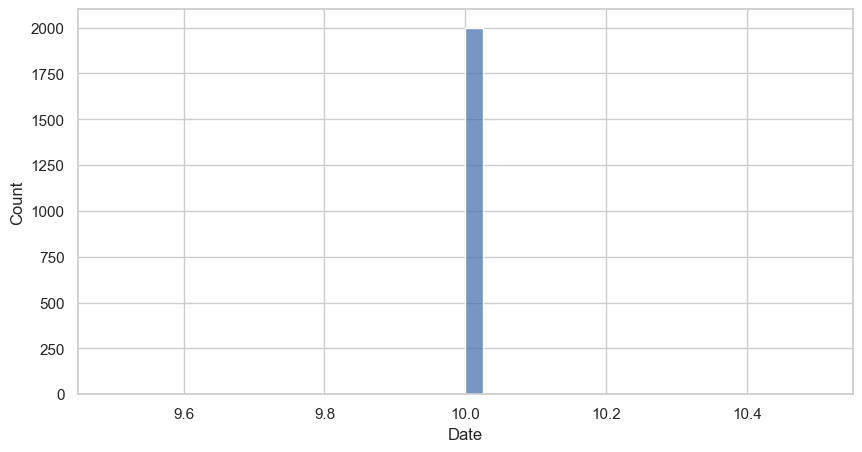

In [4]:
# Descriptive statistics for text columns (lengths, missingness)
if sample_df is not None and text_cols:
    col = text_cols[0]
    s = sample_df[col].astype(str)
    lengths = s.str.len().fillna(0)
    print('Count:', len(s))
    print('Missing:', s.isna().sum())
    print('Length stats:')
    display(lengths.describe())
    sns.histplot(lengths, bins=40);
else:
    print('No text columns available in sample to compute descriptive stats.')

In [5]:
# Token frequency (top tokens) using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stops = set(stopwords.words('english'))

if sample_df is not None and text_cols:
    texts = sample_df[text_cols[0]].fillna('').astype(str).values[:5000]
    cv = CountVectorizer(stop_words=stops, max_features=5000, ngram_range=(1,1))
    X = cv.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(cv.get_feature_names_out())
    top_idx = freqs.argsort()[::-1][:30]
    top_terms = list(zip(terms[top_idx], freqs[top_idx]))
    print('Top tokens:')
    for t,f in top_terms[:30]:
        print(f'{t}: {f}')
else:
    print('No text data for token frequency analysis.')

In [6]:
# Simple LSA topic preview (TF-IDF + TruncatedSVD)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

def show_lsa_topics(texts, n_topics=6, n_terms=8):
    tf = TfidfVectorizer(stop_words='english', max_features=5000)
    X = tf.fit_transform(texts)
    svd = TruncatedSVD(n_components=n_topics, random_state=0)
    svd.fit(X)
    terms = tf.get_feature_names_out()
    topics = []
    for i, comp in enumerate(svd.components_):
        top_terms = [terms[j] for j in comp.argsort()[-n_terms:][::-1]]
        topics.append(top_terms)
    for i,t in enumerate(topics):
        print(f'Topic {i}:', ', '.join(t))

if sample_df is not None and text_cols:
    small_texts = sample_df[text_cols[0]].fillna('').astype(str).values[:2000]
    show_lsa_topics(small_texts, n_topics=6, n_terms=8)
else:
    print('No text data for topic modeling.')

Topic 0: 08, 10, 06, 03, 11, 09, 05, 12
Topic 1: 08, 2016, 2013, 05, 01, 07, 04, 11
Topic 2: 07, 10, 01, 09, 06, 08, 2015, 12
Topic 3: 06, 10, 2016, 2015, 2009, 04, 02, 25
Topic 4: 10, 07, 2016, 11, 2014, 03, 02, 2013
Topic 5: 2013, 04, 05, 2015, 02, 10, 2009, 12


Using date column: Date


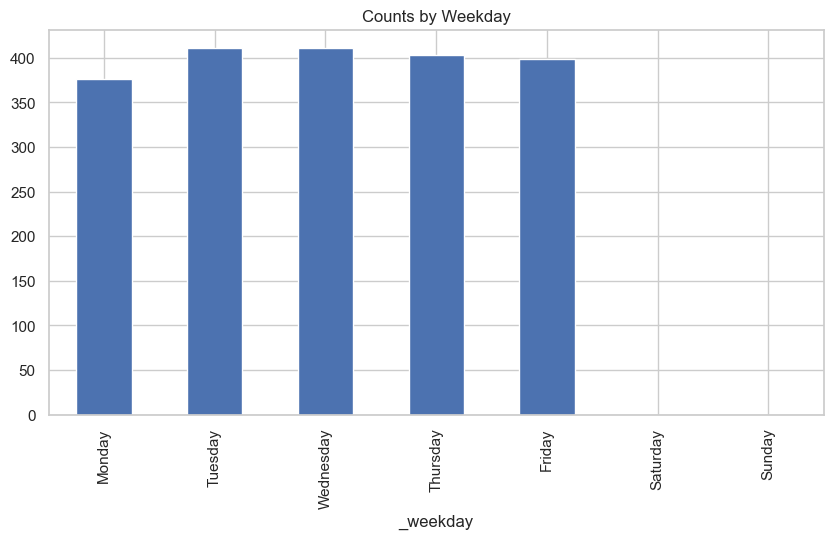

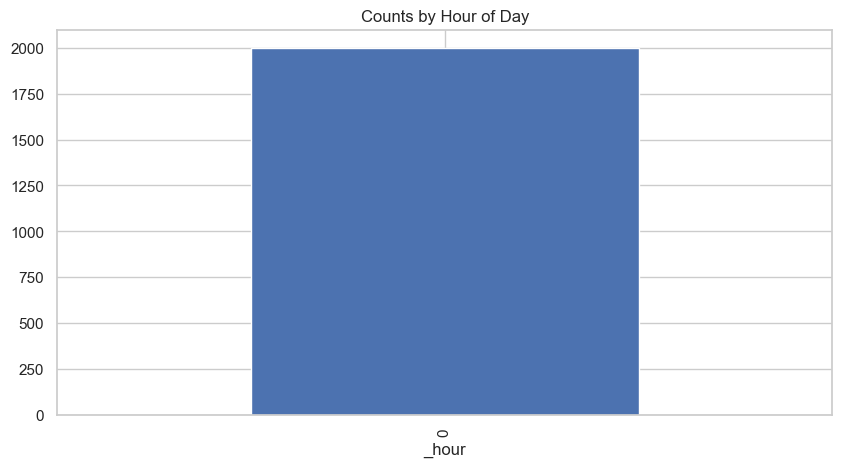

In [ ]:
# Time-based publisher analysis (if date/publisher columns exist)
date_col = None
for c in possible_date_cols:
    try:
        tmp = pd.to_datetime(sample_df[c], errors='coerce')
        if tmp.notna().sum() > 0:
            date_col = c
            break
    except Exception:
        continue

if date_col is not None:
    print('Using date column:', date_col)
    sample_df['_when'] = pd.to_datetime(sample_df[date_col], errors='coerce')
    sample_df['_weekday'] = sample_df['_when'].dt.day_name()
    sample_df['_hour'] = sample_df['_when'].dt.hour
    # publisher column detection
    publisher_cols = [c for c in sample_df.columns if 'publisher' in c.lower() or 'source' in c.lower()]
    publisher = publisher_cols[0] if publisher_cols else None
    # show counts by weekday and hour
    wd = sample_df.groupby('_weekday').size().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).fillna(0)
    wd.plot(kind='bar');
    plt.title('Counts by Weekday')
    plt.show()
    hr = sample_df.groupby('_hour').size()
    hr.plot(kind='bar');
    plt.title('Counts by Hour of Day')
    plt.show()
    if publisher is not None:
        print('Using publisher column:', publisher)
        top_publishers = sample_df[publisher].value_counts().head(10)
        display(top_publishers)
else:
    print('No parsable date column found in sample; skipping time-based analysis.')